In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# Carregar dados da planilha com data augmentation
df_treinamento = pd.read_excel("dados_treinamento_aumentado.xlsx")

df_validacao = pd.read_excel("dados_validacao.xlsx")

df_treinamento_sem_aumento = pd.read_excel("dados_treinamento.xlsx")

Top 10 correlações mais fortes (positivas):
Kidscore       0.050176
Estágio        0.049417
tB-tSB         0.033705
Morfo          0.030185
tSC            0.028430
Padrão         0.021482
cc3 (t5-t3)    0.020925
t2             0.016432
t8             0.015863
t5             0.013381
Name: Ploidia, dtype: float64

Top 10 correlações mais fracas (negativas):
tB             0.013315
t3             0.011454
cc2 (t3-t2)    0.006703
t5-t2          0.006534
Idade         -0.005777
tSB           -0.010337
tSC-t8        -0.024579
s2 (t4-t3)    -0.025624
s3 (t8-t5)    -0.026306
t4            -0.026702
Name: Ploidia, dtype: float64


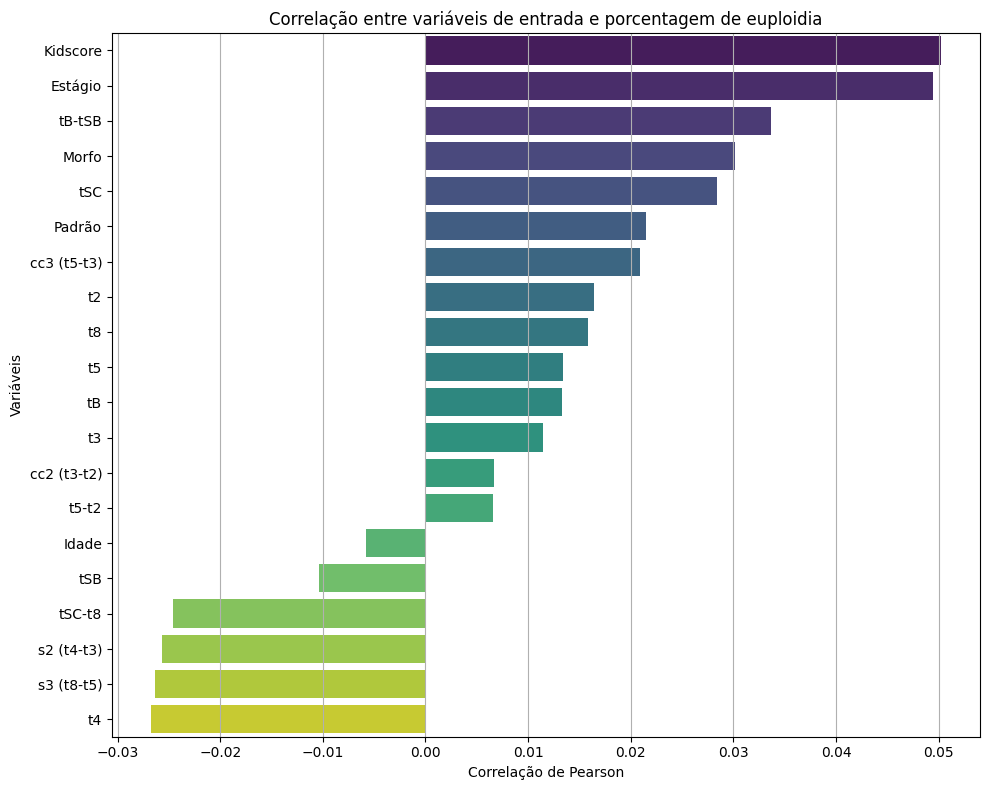

In [16]:
# Verificar se a coluna alvo existe
coluna_alvo = "Ploidia" if "Ploidia" in df_treinamento.columns else df_treinamento.columns[-1]

# Calcular correlação de Pearson entre variáveis e a variável-alvo
correlacoes = df_treinamento.corr(numeric_only=True)[coluna_alvo].drop(coluna_alvo).sort_values(ascending=False)

# Exibir top 10 correlações positivas
print("Top 10 correlações mais fortes (positivas):")
print(correlacoes.head(10))

# Exibir top 10 correlações negativas
print("\nTop 10 correlações mais fracas (negativas):")
print(correlacoes.tail(10))

# Gerar gráfico de correlação
plt.figure(figsize=(10, 8))
sns.barplot(x=correlacoes.values, y=correlacoes.index, hue=correlacoes.index, palette="viridis", dodge=False,)
plt.title("Correlação entre variáveis de entrada e porcentagem de euploidia")
plt.xlabel("Correlação de Pearson")
plt.ylabel("Variáveis")
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()

Nenhuma variável está fortemente correlacionada com Ploidia de forma linear.  Quando a variável-alvo é binária,  a correlação de Pearson deixa de ser o método ideal para medir a associação entre variáveis contínuas e essa variável de classe.

A **correlação de Pearson** assume que ambas as variáveis são contínuas e normalmente distribuídas. Quando uma delas é binária (0 ou 1), isso causa:
- Limitações estatísticas, porque a variável-alvo não tem variação contínua suficiente.
- Subestimação de relações não lineares ou categóricas.

A **correlação bisserial pontual** mede a força e a direção da relação entre uma variável contínua e uma variável binária (como a sua Ploidia). Ela varia de -1 a 1:
- Valores próximos de 1 indicam uma forte correlação positiva.
- Valores próximos de -1 indicam uma forte correlação negativa.
- Valores próximos de 0 indicam que não há correlação linear significativa.


In [17]:
#correlação bisserial pontual (PointBiserial
for coluna in df_treinamento.columns:
    if coluna != "Ploidia" and pd.api.types.is_numeric_dtype(df_treinamento[coluna]):
        coef, p = pointbiserialr(df_treinamento[coluna], df_treinamento["Ploidia"])
        print(f"{coluna}: correlação = {coef:.3f}, p-valor = {p:.4f}")

Idade: correlação = -0.006, p-valor = 0.8082
Estágio: correlação = 0.049, p-valor = 0.0378
Morfo: correlação = 0.030, p-valor = 0.2047
Kidscore: correlação = 0.050, p-valor = 0.0349
Padrão: correlação = 0.021, p-valor = 0.3668
t2: correlação = 0.016, p-valor = 0.4900
t3: correlação = 0.011, p-valor = 0.6304
t4: correlação = -0.027, p-valor = 0.2619
t5: correlação = 0.013, p-valor = 0.5740
t8: correlação = 0.016, p-valor = 0.5052
tSC: correlação = 0.028, p-valor = 0.2323
tSB: correlação = -0.010, p-valor = 0.6641
tB: correlação = 0.013, p-valor = 0.5759
cc2 (t3-t2): correlação = 0.007, p-valor = 0.7783
cc3 (t5-t3): correlação = 0.021, p-valor = 0.3794
t5-t2: correlação = 0.007, p-valor = 0.7837
s2 (t4-t3): correlação = -0.026, p-valor = 0.2817
s3 (t8-t5): correlação = -0.026, p-valor = 0.2691
tSC-t8: correlação = -0.025, p-valor = 0.3018
tB-tSB: correlação = 0.034, p-valor = 0.1567


| Variável   | Correlação | P-valor | Interpretação                                                                                                                                |
|------------|------------|---------|---------------------------------------------------------------------------------------------------------------------------------------------|
| Idade      | -0.006     | 0.8082  | Correlação muito baixa e negativa. P-valor acima de 0.05, indicando que a Idade não tem uma relação significativa com a Ploidia.        |
| Estágio    | 0.049      | 0.0378  | Correlação positiva e pequena. P-valor abaixo de 0.05, indicando uma correlação significativa entre Estágio e Ploidia.                        |
| Morfo      | 0.030      | 0.2047  | Correlação muito baixa. P-valor acima de 0.05, indicando que não há uma correlação significativa entre Morfo e Ploidia.                    |
| Kidscore   | 0.050      | 0.0349  | Correlação positiva e pequena. P-valor abaixo de 0.05, indicando uma correlação significativa entre Kidscore e Ploidia.                       |
| Padrão     | 0.021      | 0.3668  | Correlação muito baixa. P-valor acima de 0.05, indicando que não há uma correlação significativa entre Padrão e Ploidia.                   |
| t2, t3, t4, t5, t8, tSC, tSB, tB | Varia entre 0.016 e -0.027 | Varia entre 0.1567 e 0.7837 | Correlações muito fracas. P-valores acima de 0.05, indicando que nenhuma dessas variáveis tem uma relação significativa com Ploidia. |
| c2 (t3-t2), c3 (t5-t3), t5-t2, s2 (t4-t3), s3 (t8-t5), tSC-t8, tB-tSB | Varia entre 0.007 e -0.026 | Varia entre 0.2691 e 0.7837 | Correlações muito fracas. P-valores altos, indicando que elas não têm uma relação significativa com Ploidia. |

Variáveis com correlação significativa: Estágio e Kidscore têm correlação significativa com Ploidia, embora a relação seja fraca.

Variáveis sem correlação significativa: A maioria das variáveis tem correlações fracas e p-valores acima de 0.05, indicando que não há uma relação significativa entre elas e Ploidia

In [11]:
y_treinamento = df_treinamento['Ploidia']
X_treinamento = df_treinamento.drop('Ploidia', axis=1)

# Definir as variáveis de entrada para validação
X_validacao = df_validacao.drop('Ploidia', axis=1)
y_validacao = df_validacao['Ploidia']


y_treinamento_bin = (y_treinamento > 0).astype(int)
y_validacao_bin = (y_validacao > 0).astype(int)

## Aplicação da Regressão Logística 

Acurácia do modelo nos dados de validação: 0.6666666666666666

Matriz de Confusão nos dados de validação:
[[8 0]
 [4 0]]

Relatório de Classificação nos dados de validação:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         8
           1       0.00      0.00      0.00         4

    accuracy                           0.67        12
   macro avg       0.33      0.50      0.40        12
weighted avg       0.44      0.67      0.53        12



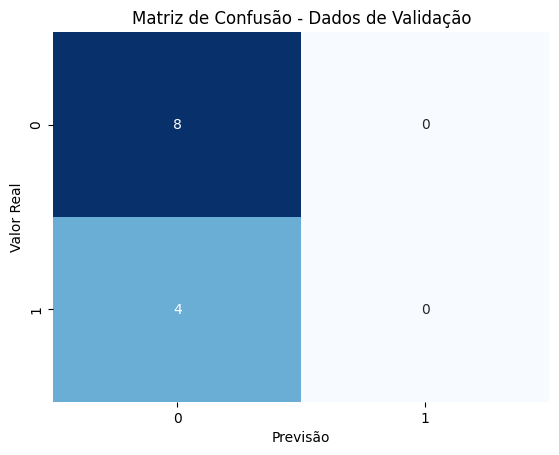


Coeficientes do modelo (para cada variável):
             Coeficiente
Idade          -0.036112
Estágio         0.057343
Morfo           0.085632
Kidscore        0.090791
Padrão         -0.015397
t2              0.059716
t3             -0.049904
t4             -0.052939
t5             -0.012233
t8              0.012478
tSC             0.096631
tSB             0.012937
tB             -0.028312
cc2 (t3-t2)     0.002152
cc3 (t5-t3)     0.042977
t5-t2           0.041006
s2 (t4-t3)     -0.051448
s3 (t8-t5)     -0.055523
tSC-t8         -0.043054
tB-tSB          0.183690


In [30]:
# Inicializar o modelo de regressão logística
modelo = LogisticRegression()

# Treinar o modelo com os dados de treinamento
modelo.fit(X_treinamento, y_treinamento_bin)

# Fazer previsões com os dados de validação
y_pred_validacao = modelo.predict(X_validacao)

# Avaliar a performance do modelo usando os dados de validação
print("Acurácia do modelo nos dados de validação:", accuracy_score(y_validacao_bin, y_pred_validacao))
print("\nMatriz de Confusão nos dados de validação:")
print(confusion_matrix(y_validacao_bin, y_pred_validacao))
print("\nRelatório de Classificação nos dados de validação:")
print(classification_report(y_validacao_bin, y_pred_validacao,  zero_division=0))

# Gerar gráfico de confusão para os dados de validação
sns.heatmap(confusion_matrix(y_validacao_bin, y_pred_validacao), annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title("Matriz de Confusão - Dados de Validação")
plt.xlabel("Previsão")
plt.ylabel("Valor Real")
plt.show()

# Exibir os coeficientes do modelo (para cada variável)
print("\nCoeficientes do modelo (para cada variável):")
coef_df = pd.DataFrame(modelo.coef_.T, index=X_treinamento.columns, columns=['Coeficiente'])
print(coef_df)

A acurácia de 66,7% das previsões do modelo estão corretas (8 acertos de 12 casos).
- MAS: essa métrica é enganosa quando há desbalanceamento de classes (como parece ser o caso aqui).

Matriz de confusão:
- Linha 1 (classe 0 – Ploidia): o modelo previu corretamente 8 casos como 0 e nenhum erro.
- Linha 2 (classe 1 – Aneuploidia): o modelo errou todos os 4 casos da classe 1 — ou seja, não previu nenhum como 1.

Coeficientes do Modelo:
- Um coeficiente positivo → variável está associada com maior chance da classe ser 1 (aneuploidia).
- Um coeficiente negativo → variável está associada com maior chance da classe ser 0 (ploidia).

In [31]:
print(y_treinamento_bin.value_counts())
print(y_validacao_bin.value_counts())

Ploidia
0    1159
1     608
Name: count, dtype: int64
Ploidia
0    8
1    4
Name: count, dtype: int64


Acurácia do modelo nos dados de validação: 0.5833333333333334

Matriz de Confusão nos dados de validação:
[[5 3]
 [2 2]]

Relatório de Classificação nos dados de validação:
              precision    recall  f1-score   support

           0       0.71      0.62      0.67         8
           1       0.40      0.50      0.44         4

    accuracy                           0.58        12
   macro avg       0.56      0.56      0.56        12
weighted avg       0.61      0.58      0.59        12



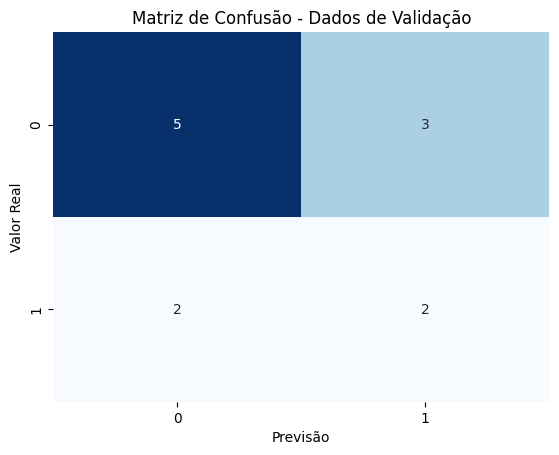


Coeficientes do modelo (para cada variável):
             Coeficiente
Idade          -0.037806
Estágio         0.053836
Morfo           0.085070
Kidscore        0.090396
Padrão         -0.016345
t2              0.064411
t3             -0.051209
t4             -0.054365
t5             -0.010568
t8              0.013672
tSC             0.093639
tSB             0.011619
tB             -0.030434
cc2 (t3-t2)     0.002999
cc3 (t5-t3)     0.044680
t5-t2           0.041768
s2 (t4-t3)     -0.050454
s3 (t8-t5)     -0.052724
tSC-t8         -0.042575
tB-tSB          0.186433


In [32]:
# Isso força o modelo a dar mais peso à classe minoritária.
modelo = LogisticRegression(class_weight='balanced')

modelo.fit(X_treinamento, y_treinamento_bin)
y_pred_validacao = modelo.predict(X_validacao)

# Avaliar a performance do modelo usando os dados de validação
print("Acurácia do modelo nos dados de validação:", accuracy_score(y_validacao_bin, y_pred_validacao))
print("\nMatriz de Confusão nos dados de validação:")
print(confusion_matrix(y_validacao_bin, y_pred_validacao))
print("\nRelatório de Classificação nos dados de validação:")
print(classification_report(y_validacao_bin, y_pred_validacao,  zero_division=0))

# Gerar gráfico de confusão para os dados de validação
sns.heatmap(confusion_matrix(y_validacao_bin, y_pred_validacao), annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title("Matriz de Confusão - Dados de Validação")
plt.xlabel("Previsão")
plt.ylabel("Valor Real")
plt.show()

# Exibir os coeficientes do modelo (para cada variável)
print("\nCoeficientes do modelo (para cada variável):")
coef_df = pd.DataFrame(modelo.coef_.T, index=X_treinamento.columns, columns=['Coeficiente'])
print(coef_df)

A acurácia de 66,7% das previsões do modelo estão corretas (8 acertos de 12 casos).
- MAS: essa métrica é enganosa quando há desbalanceamento de classes (como parece ser o caso aqui).

Matriz de confusão:
- Linha 1 (classe 0 – Ploidia): o modelo previu corretamente 8 casos como 0 e nenhum erro.
- Linha 2 (classe 1 – Aneuploidia): o modelo errou todos os 4 casos da classe 1 — ou seja, não previu nenhum como 1.

Coeficientes do Modelo:
- Um coeficiente positivo → variável está associada com maior chance da classe ser 1 (aneuploidia).
- Um coeficiente negativo → variável está associada com maior chance da classe ser 0 (ploidia).

### Usando a planilha sem o aumento de dados 

# Separar variáveis independentes e alvo nos dados sem aumento
X_treinamento_sem_aumento = df_treinamento_sem_aumento.drop('Ploidia', axis=1)
y_treinamento_sem_aumento = df_treinamento_sem_aumento['Ploidia']

X_validacao_sem_aumento = df_validacao.drop('Ploidia', axis=1)
y_validacao_sem_aumento = df_validacao['Ploidia']

y_treinamento_sem_aumento_bin = (y_treinamento_sem_aumento > 0).astype(int)
y_validacao_sem_aumento_bin = (y_validacao_sem_aumento > 0).astype(int)

modelo_sem_aumento = LogisticRegression(max_iter=1000)
modelo_sem_aumento.fit(X_treinamento_sem_aumento, y_treinamento_sem_aumento_bin)

# Fazer previsões
y_pred_sem_aumento = modelo_sem_aumento.predict(X_validacao_sem_aumento)

# Avaliação
print("Acurácia (sem aumento):", accuracy_score(y_validacao_sem_aumento_bin, y_pred_sem_aumento))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_validacao_sem_aumento_bin, y_pred_sem_aumento))
print("\nRelatório de Classificação:")
print(classification_report(y_validacao_sem_aumento_bin, y_pred_sem_aumento, zero_division=0))


# Plotar matriz de confusão
sns.heatmap(confusion_matrix(y_validacao_sem_aumento_bin, y_pred_sem_aumento), annot=True, fmt='d', cmap="Oranges", cbar=False)
plt.title("Matriz de Confusão - Sem Data Augmentation")
plt.xlabel("Previsão")
plt.ylabel("Valor Real")
plt.show()

# Exibir coeficientes
coef_df_sem = pd.DataFrame(modelo_sem_aumento.coef_.T, index=X_treinamento_sem_aumento.columns, columns=['Coeficiente'])
print("\nCoeficientes do modelo (sem aumento):")
print(coef_df_sem)


- Equilíbrio razoável: o modelo acerta metade da classe minoritária.
- Coeficientes têm valores altos → possível overfitting devido ao conjunto pequeno.

- Parece ser o modelo com melhor equilíbrio entre precisão e sensibilidade.

## Aplicação de Random Forest

In [12]:
# Inicializa o modelo com pesos balanceados
modelo_rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Treina o modelo
modelo_rf.fit(X_treinamento, y_treinamento_bin)

# Faz predições
y_pred_rf = modelo_rf.predict(X_validacao)

# Avalia
print("Acurácia do modelo Random Forest nos dados de validação:", accuracy_score(y_validacao_bin, y_pred_rf))
print("\nMatriz de Confusão:")
print(confusion_matrix(y_validacao_bin, y_pred_rf))
print("\nRelatório de Classificação:")
print(classification_report(y_validacao_bin, y_pred_rf, zero_division=0))

Acurácia do modelo Random Forest nos dados de validação: 0.3333333333333333

Matriz de Confusão:
[[3 5]
 [3 1]]

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.50      0.38      0.43         8
           1       0.17      0.25      0.20         4

    accuracy                           0.33        12
   macro avg       0.33      0.31      0.31        12
weighted avg       0.39      0.33      0.35        12



In [15]:
#usando validação cruzada
modelo = RandomForestClassifier(class_weight='balanced', random_state=42)
scores = cross_val_score(modelo, X_treinamento, y_treinamento_bin, cv=5)

print("Acurácias em cada rodada:", scores)
print("Média da acurácia:", scores.mean())

Acurácias em cada rodada: [0.50847458 0.50847458 0.5184136  0.48725212 0.50424929]
Média da acurácia: 0.5053728333413359
